In [1]:
!pip install requests tqdm torch torchvision pycocotools pillow

In [2]:
import os
import json
import requests
from tqdm import tqdm
import zipfile
import io

def download_subset_coco(num_images=1000):
    """
    Download a subset of COCO dataset
    """
    # Create directories
    os.makedirs('coco/images', exist_ok=True)
    os.makedirs('coco/annotations', exist_ok=True)

    # Download annotations file using requests
    annotation_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    print("Downloading annotation file...")

    try:
        response = requests.get(annotation_url, stream=True)
        if response.status_code == 200:
            # Write the zip file
            with open('annotations.zip', 'wb') as f:
                f.write(response.content)

            # Extract the zip file
            with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
                zip_ref.extractall('.')

            # Remove the zip file
            os.remove('annotations.zip')
        else:
            raise Exception(f"Failed to download annotations: Status code {response.status_code}")

        # Load annotations
        with open('annotations/captions_train2017.json', 'r') as f:
            annotations = json.load(f)

        # Get subset of images and their annotations
        subset_images = annotations['images'][:num_images]
        image_ids = [img['id'] for img in subset_images]
        subset_annotations = [ann for ann in annotations['annotations']
                            if ann['image_id'] in image_ids]

        # Create new annotation file with subset
        subset_data = {
            'info': annotations['info'],
            'licenses': annotations['licenses'],
            'images': subset_images,
            'annotations': subset_annotations
        }

        # Save subset annotations
        with open('coco/annotations/captions_subset_train2017.json', 'w') as f:
            json.dump(subset_data, f)

        # Download subset of images
        print(f"\nDownloading {num_images} images...")
        for img in tqdm(subset_images):
            img_url = f"http://images.cocodataset.org/train2017/{img['file_name']}"
            img_path = f"coco/images/{img['file_name']}"

            # Download image if it doesn't exist
            if not os.path.exists(img_path):
                try:
                    response = requests.get(img_url)
                    if response.status_code == 200:
                        with open(img_path, 'wb') as f:
                            f.write(response.content)
                except Exception as e:
                    print(f"Error downloading {img['file_name']}: {str(e)}")

        print("\nCleanup...")
        # Remove the annotations directory after we're done
        if os.path.exists('annotations'):
            import shutil
            shutil.rmtree('annotations')

        return 'coco/images', 'coco/annotations/captions_subset_train2017.json'

    except Exception as e:
        print(f"Error during download: {str(e)}")
        raise

# For testing the download function independently
if __name__ == "__main__":
    images_dir, annotations_file = download_subset_coco(num_images=1000)
    print(f"\nDownload complete!")
    print(f"Images directory: {images_dir}")
    print(f"Annotations file: {annotations_file}")

100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]



Cleanup...

Download complete!
Images directory: coco/images
Annotations file: coco/annotations/captions_subset_train2017.json


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm
from collections import Counter
import os

class ImageCaptioningDataset(Dataset):
    def __init__(self, root_dir, annotations_file, transform=None, max_samples=1000):
        self.root_dir = root_dir
        self.transform = transform

        print(f"Loading annotations from: {annotations_file}")
        self.coco = COCO(annotations_file)

        # Get image ids and limit to max_samples
        self.img_ids = list(self.coco.imgs.keys())[:max_samples]
        print(f"Number of images loaded: {len(self.img_ids)}")

        # Build vocabulary
        self.word_freq = Counter()
        self.captions = []
        print("Building vocabulary...")
        for img_id in tqdm(self.img_ids):
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                caption = ann['caption'].lower().split()
                self.word_freq.update(caption)
                self.captions.append(caption)

        # Create word to index mapping
        words = [word for word, freq in self.word_freq.items() if freq > 5]
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.word2idx.update({word: idx + 4 for idx, word in enumerate(words)})
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        print(f"Vocabulary size: {len(self.word2idx)}")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)

            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            caption = anns[0]['caption'].lower().split()

            caption = ['<START>'] + caption + ['<END>']
            caption = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in caption]

            return image, torch.tensor(caption)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return None

    def collate_fn(self, batch):
        batch = [item for item in batch if item is not None]
        if len(batch) == 0:
            return None

        images, captions = zip(*batch)
        images = torch.stack(images)

        caption_lengths = [len(cap) for cap in captions]
        max_length = max(caption_lengths)

        padded_captions = torch.zeros(len(captions), max_length).long()
        for i, cap in enumerate(captions):
            end = caption_lengths[i]
            padded_captions[i, :end] = cap[:end]

        return images, padded_captions

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # Embed the captions
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)

        # Prepare the feature vector
        features = features.unsqueeze(1)

        # Concatenate feature vector with embedded captions
        inputs = torch.cat((features, embeddings), dim=1)

        # Pass through LSTM
        hiddens, _ = self.lstm(inputs)

        # Get outputs
        outputs = self.linear(hiddens)

        return outputs[:, :-1, :]  # Remove the last prediction to match target length

def train_model(encoder, decoder, train_loader, criterion, encoder_optimizer,
                decoder_optimizer, device, num_epochs=10):
    print("Starting training...")
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0
        n_batches = 0

        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            if batch is None:
                continue

            images, captions = batch
            batch_size = images.size(0)

            # Move to device
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            try:
                # Forward pass
                features = encoder(images)

                # Get inputs and targets
                inputs = captions[:, :-1]  # All tokens except the last one
                targets = captions[:, 1:]  # All tokens except the first one

                # Generate outputs
                outputs = decoder(features, inputs)

                # Flatten outputs and targets for loss calculation
                seq_length = outputs.size(1)
                outputs = outputs.reshape(-1, outputs.size(2))
                targets = targets[:, :seq_length].contiguous().view(-1)

                # Calculate loss
                loss = criterion(outputs, targets)

                # Backward pass
                loss.backward()

                # Update weights
                encoder_optimizer.step()
                decoder_optimizer.step()

                total_loss += loss.item()
                n_batches += 1

                if i % 5 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

            except Exception as e:
                print(f"Error in batch {i}: {str(e)}")
                continue

        # Calculate average loss for the epoch
        avg_loss = total_loss / n_batches if n_batches > 0 else float('inf')
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Save checkpoint
        checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': avg_loss,
            'vocab_size': len(dataset.word2idx),
            'word2idx': dataset.word2idx,
            'idx2word': dataset.idx2word
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.01
num_epochs = 10
batch_size = 16

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = ImageCaptioningDataset(
    root_dir='coco/images',
    annotations_file='coco/annotations/captions_subset_train2017.json',
    transform=transform,
    max_samples=1000
)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=dataset.collate_fn,
    num_workers=0  # Set to 0 for debugging
)

# Initialize models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(dataset.word2idx)).to(device)

# Loss and optimizers
criterion = nn.CrossEntropyLoss(ignore_index=dataset.word2idx['<PAD>'])
# encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate)
encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=learning_rate, weight_decay=1e-4)
decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-4)
# Train the model
train_model(encoder, decoder, train_loader, criterion, encoder_optimizer,
            decoder_optimizer, device, num_epochs)






def generate_caption(encoder, decoder, image_path, transform, word2idx, idx2word, device, max_length=50):
    """Generate a caption for a given image"""
    encoder.eval()
    decoder.eval()

    # Prepare the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Generate caption
    with torch.no_grad():
        features = encoder(image)

        # Initialize the caption with START token
        caption = [word2idx['<START>']]

        # Generate words until END token or max length
        for i in range(max_length):
            current_word_idx = torch.tensor(caption).unsqueeze(0).to(device)
            output = decoder(features, current_word_idx)
            predicted = output[0, -1].argmax().item()

            caption.append(predicted)

            if predicted == word2idx['<END>']:
                break

    # Convert indices to words
    caption_words = [idx2word[idx] for idx in caption]
    # Remove special tokens
    caption_words = caption_words[1:-1]  # Remove START and END tokens

    return ' '.join(caption_words)

# Example usage:
def test_model(checkpoint_path, test_image_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Initialize models with same parameters as training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(dataset.word2idx)).to(device)

    # Load the saved state
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # Generate caption
    caption = generate_caption(encoder, decoder, test_image_path, transform,
                             dataset.word2idx, dataset.idx2word, device)

    print(f"Generated caption: {caption}")

Using device: cpu
Loading annotations from: coco/annotations/captions_subset_train2017.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of images loaded: 1000
Building vocabulary...


100%|██████████| 1000/1000 [00:00<00:00, 39729.32it/s]

Vocabulary size: 890


Starting training...


Epoch 1/10:   2%|▏         | 1/63 [00:04<04:23,  4.26s/it]

Epoch [1/10], Step [0/63], Loss: 6.7861


Epoch 1/10:  10%|▉         | 6/63 [00:27<04:24,  4.64s/it]

Epoch [1/10], Step [5/63], Loss: 5.2542


Epoch 1/10:  17%|█▋        | 11/63 [00:51<04:05,  4.73s/it]

Epoch [1/10], Step [10/63], Loss: 4.8790


Epoch 1/10:  25%|██▌       | 16/63 [01:13<03:37,  4.62s/it]

Epoch [1/10], Step [15/63], Loss: 4.4425


Epoch 1/10:  33%|███▎      | 21/63 [01:36<03:11,  4.55s/it]

Epoch [1/10], Step [20/63], Loss: 4.6140


Epoch 1/10:  41%|████▏     | 26/63 [02:00<02:49,  4.58s/it]

Epoch [1/10], Step [25/63], Loss: 4.4856


Epoch 1/10:  49%|████▉     | 31/63 [02:23<02:28,  4.65s/it]

Epoch [1/10], Step [30/63], Loss: 4.5412


Epoch 1/10:  57%|█████▋    | 36/63 [02:46<02:08,  4.75s/it]

Epoch [1/10], Step [35/63], Loss: 4.3408


Epoch 1/10:  65%|██████▌   | 41/63 [03:09<01:40,  4.57s/it]

Epoch [1/10], Step [40/63], Loss: 4.5906


Epoch 1/10:  73%|███████▎  | 46/63 [03:32<01:17,  4.55s/it]

Epoch [1/10], Step [45/63], Loss: 4.0131


Epoch 1/10:  81%|████████  | 51/63 [03:55<00:55,  4.59s/it]

Epoch [1/10], Step [50/63], Loss: 4.5474


Epoch 1/10:  89%|████████▉ | 56/63 [04:19<00:32,  4.66s/it]

Epoch [1/10], Step [55/63], Loss: 4.3191


Epoch 1/10:  97%|█████████▋| 61/63 [04:42<00:09,  4.77s/it]

Epoch [1/10], Step [60/63], Loss: 4.1962


Epoch 1/10: 100%|██████████| 63/63 [04:48<00:00,  4.58s/it]


Epoch [1/10], Average Loss: 4.5618
Checkpoint saved: checkpoint_epoch_1.pth


Epoch 2/10:   2%|▏         | 1/63 [00:05<05:13,  5.05s/it]

Epoch [2/10], Step [0/63], Loss: 3.7006


Epoch 2/10:  10%|▉         | 6/63 [00:27<04:17,  4.53s/it]

Epoch [2/10], Step [5/63], Loss: 3.4456


Epoch 2/10:  17%|█▋        | 11/63 [00:50<03:56,  4.55s/it]

Epoch [2/10], Step [10/63], Loss: 3.5580


Epoch 2/10:  25%|██▌       | 16/63 [01:13<03:37,  4.63s/it]

Epoch [2/10], Step [15/63], Loss: 3.5544


Epoch 2/10:  33%|███▎      | 21/63 [01:37<03:18,  4.73s/it]

Epoch [2/10], Step [20/63], Loss: 4.0306


Epoch 2/10:  41%|████▏     | 26/63 [01:59<02:45,  4.47s/it]

Epoch [2/10], Step [25/63], Loss: 3.8636


Epoch 2/10:  49%|████▉     | 31/63 [02:22<02:24,  4.53s/it]

Epoch [2/10], Step [30/63], Loss: 3.4764


Epoch 2/10:  57%|█████▋    | 36/63 [02:45<02:04,  4.61s/it]

Epoch [2/10], Step [35/63], Loss: 3.4332


Epoch 2/10:  65%|██████▌   | 41/63 [03:08<01:42,  4.67s/it]

Epoch [2/10], Step [40/63], Loss: 3.7671


Epoch 2/10:  73%|███████▎  | 46/63 [03:32<01:19,  4.68s/it]

Epoch [2/10], Step [45/63], Loss: 3.6319


Epoch 2/10:  81%|████████  | 51/63 [03:54<00:54,  4.50s/it]

Epoch [2/10], Step [50/63], Loss: 3.5476


Epoch 2/10:  89%|████████▉ | 56/63 [04:17<00:31,  4.55s/it]

Epoch [2/10], Step [55/63], Loss: 3.8904


Epoch 2/10:  97%|█████████▋| 61/63 [04:40<00:09,  4.64s/it]

Epoch [2/10], Step [60/63], Loss: 3.6521


Epoch 2/10: 100%|██████████| 63/63 [04:47<00:00,  4.56s/it]


Epoch [2/10], Average Loss: 3.6768
Checkpoint saved: checkpoint_epoch_2.pth


Epoch 3/10:   2%|▏         | 1/63 [00:05<05:25,  5.25s/it]

Epoch [3/10], Step [0/63], Loss: 3.2069


Epoch 3/10:  10%|▉         | 6/63 [00:28<04:33,  4.80s/it]

Epoch [3/10], Step [5/63], Loss: 3.0122


Epoch 3/10:  17%|█▋        | 11/63 [00:51<03:54,  4.52s/it]

Epoch [3/10], Step [10/63], Loss: 3.3166


Epoch 3/10:  25%|██▌       | 16/63 [01:14<03:34,  4.57s/it]

Epoch [3/10], Step [15/63], Loss: 3.6259


Epoch 3/10:  33%|███▎      | 21/63 [01:37<03:14,  4.64s/it]

Epoch [3/10], Step [20/63], Loss: 3.0086


Epoch 3/10:  41%|████▏     | 26/63 [02:00<02:53,  4.70s/it]

Epoch [3/10], Step [25/63], Loss: 3.0101


Epoch 3/10:  49%|████▉     | 31/63 [02:29<02:58,  5.58s/it]

Epoch [3/10], Step [30/63], Loss: 3.1845


Epoch 3/10:  57%|█████▋    | 36/63 [02:52<02:15,  5.01s/it]

Epoch [3/10], Step [35/63], Loss: 3.3000


Epoch 3/10:  65%|██████▌   | 41/63 [03:16<01:44,  4.73s/it]

Epoch [3/10], Step [40/63], Loss: 3.4942


Epoch 3/10:  73%|███████▎  | 46/63 [03:40<01:19,  4.69s/it]

Epoch [3/10], Step [45/63], Loss: 3.3307


Epoch 3/10:  81%|████████  | 51/63 [04:04<00:57,  4.79s/it]

Epoch [3/10], Step [50/63], Loss: 3.3775


Epoch 3/10:  89%|████████▉ | 56/63 [04:28<00:33,  4.77s/it]

Epoch [3/10], Step [55/63], Loss: 3.4362


Epoch 3/10:  97%|█████████▋| 61/63 [04:52<00:09,  4.79s/it]

Epoch [3/10], Step [60/63], Loss: 3.2235


Epoch 3/10: 100%|██████████| 63/63 [04:58<00:00,  4.74s/it]


Epoch [3/10], Average Loss: 3.2861
Checkpoint saved: checkpoint_epoch_3.pth


Epoch 4/10:   2%|▏         | 1/63 [00:05<05:46,  5.59s/it]

Epoch [4/10], Step [0/63], Loss: 2.8067


Epoch 4/10:  10%|▉         | 6/63 [00:29<04:37,  4.87s/it]

Epoch [4/10], Step [5/63], Loss: 2.9586


Epoch 4/10:  17%|█▋        | 11/63 [00:51<03:55,  4.53s/it]

Epoch [4/10], Step [10/63], Loss: 2.6488


Epoch 4/10:  25%|██▌       | 16/63 [01:14<03:35,  4.59s/it]

Epoch [4/10], Step [15/63], Loss: 2.7886


Epoch 4/10:  33%|███▎      | 21/63 [01:38<03:15,  4.67s/it]

Epoch [4/10], Step [20/63], Loss: 3.1370


Epoch 4/10:  41%|████▏     | 26/63 [02:01<02:54,  4.72s/it]

Epoch [4/10], Step [25/63], Loss: 2.9606


Epoch 4/10:  49%|████▉     | 31/63 [02:25<02:32,  4.78s/it]

Epoch [4/10], Step [30/63], Loss: 2.9007


Epoch 4/10:  57%|█████▋    | 36/63 [02:48<02:02,  4.54s/it]

Epoch [4/10], Step [35/63], Loss: 3.0008


Epoch 4/10:  65%|██████▌   | 41/63 [03:11<01:41,  4.60s/it]

Epoch [4/10], Step [40/63], Loss: 3.3177


Epoch 4/10:  73%|███████▎  | 46/63 [03:35<01:19,  4.66s/it]

Epoch [4/10], Step [45/63], Loss: 2.8595


Epoch 4/10:  81%|████████  | 51/63 [03:58<00:57,  4.75s/it]

Epoch [4/10], Step [50/63], Loss: 3.0956


Epoch 4/10:  89%|████████▉ | 56/63 [04:22<00:33,  4.84s/it]

Epoch [4/10], Step [55/63], Loss: 3.2727


Epoch 4/10:  97%|█████████▋| 61/63 [04:45<00:09,  4.57s/it]

Epoch [4/10], Step [60/63], Loss: 3.0248


Epoch 4/10: 100%|██████████| 63/63 [04:52<00:00,  4.64s/it]


Epoch [4/10], Average Loss: 2.9691
Checkpoint saved: checkpoint_epoch_4.pth


Epoch 5/10:   2%|▏         | 1/63 [00:04<04:44,  4.59s/it]

Epoch [5/10], Step [0/63], Loss: 2.4745


Epoch 5/10:  10%|▉         | 6/63 [00:27<04:22,  4.60s/it]

Epoch [5/10], Step [5/63], Loss: 2.2322


Epoch 5/10:  17%|█▋        | 11/63 [00:51<04:03,  4.69s/it]

Epoch [5/10], Step [10/63], Loss: 2.7232


Epoch 5/10:  25%|██▌       | 16/63 [01:15<03:43,  4.76s/it]

Epoch [5/10], Step [15/63], Loss: 2.4728


Epoch 5/10:  33%|███▎      | 21/63 [01:38<03:16,  4.68s/it]

Epoch [5/10], Step [20/63], Loss: 2.5742


Epoch 5/10:  41%|████▏     | 26/63 [02:01<02:47,  4.53s/it]

Epoch [5/10], Step [25/63], Loss: 2.8451


Epoch 5/10:  49%|████▉     | 31/63 [02:24<02:26,  4.58s/it]

Epoch [5/10], Step [30/63], Loss: 2.9394


Epoch 5/10:  57%|█████▋    | 36/63 [02:47<02:06,  4.67s/it]

Epoch [5/10], Step [35/63], Loss: 3.0932


Epoch 5/10:  65%|██████▌   | 41/63 [03:11<01:44,  4.75s/it]

Epoch [5/10], Step [40/63], Loss: 2.8520


Epoch 5/10:  73%|███████▎  | 46/63 [03:33<01:17,  4.55s/it]

Epoch [5/10], Step [45/63], Loss: 3.1122


Epoch 5/10:  81%|████████  | 51/63 [03:56<00:54,  4.55s/it]

Epoch [5/10], Step [50/63], Loss: 2.9079


Epoch 5/10:  89%|████████▉ | 56/63 [04:20<00:32,  4.61s/it]

Epoch [5/10], Step [55/63], Loss: 3.0427


Epoch 5/10:  97%|█████████▋| 61/63 [04:43<00:09,  4.69s/it]

Epoch [5/10], Step [60/63], Loss: 2.7159


Epoch 5/10: 100%|██████████| 63/63 [04:49<00:00,  4.60s/it]


Epoch [5/10], Average Loss: 2.7019
Checkpoint saved: checkpoint_epoch_5.pth


Epoch 6/10:   2%|▏         | 1/63 [00:05<05:44,  5.56s/it]

Epoch [6/10], Step [0/63], Loss: 2.1236


Epoch 6/10:  10%|▉         | 6/63 [00:28<04:25,  4.67s/it]

Epoch [6/10], Step [5/63], Loss: 2.4552


Epoch 6/10:  17%|█▋        | 11/63 [00:51<03:55,  4.52s/it]

Epoch [6/10], Step [10/63], Loss: 2.3458


Epoch 6/10:  25%|██▌       | 16/63 [01:14<03:35,  4.59s/it]

Epoch [6/10], Step [15/63], Loss: 2.4367


Epoch 6/10:  33%|███▎      | 21/63 [01:43<03:43,  5.31s/it]

Epoch [6/10], Step [20/63], Loss: 2.5567


Epoch 6/10:  41%|████▏     | 26/63 [02:07<02:58,  4.82s/it]

Epoch [6/10], Step [25/63], Loss: 2.2706


Epoch 6/10:  49%|████▉     | 31/63 [02:31<02:33,  4.81s/it]

Epoch [6/10], Step [30/63], Loss: 2.4804


Epoch 6/10:  57%|█████▋    | 36/63 [02:55<02:09,  4.81s/it]

Epoch [6/10], Step [35/63], Loss: 2.5395


Epoch 6/10:  65%|██████▌   | 41/63 [03:19<01:48,  4.94s/it]

Epoch [6/10], Step [40/63], Loss: 2.5460


Epoch 6/10:  73%|███████▎  | 46/63 [03:43<01:20,  4.72s/it]

Epoch [6/10], Step [45/63], Loss: 2.6029


Epoch 6/10:  81%|████████  | 51/63 [04:07<00:56,  4.71s/it]

Epoch [6/10], Step [50/63], Loss: 2.6194


Epoch 6/10:  89%|████████▉ | 56/63 [04:31<00:33,  4.72s/it]

Epoch [6/10], Step [55/63], Loss: 2.7045


Epoch 6/10:  97%|█████████▋| 61/63 [04:55<00:09,  4.80s/it]

Epoch [6/10], Step [60/63], Loss: 2.7913


Epoch 6/10: 100%|██████████| 63/63 [05:02<00:00,  4.80s/it]


Epoch [6/10], Average Loss: 2.5345
Checkpoint saved: checkpoint_epoch_6.pth


Epoch 7/10:   2%|▏         | 1/63 [00:04<05:04,  4.91s/it]

Epoch [7/10], Step [0/63], Loss: 1.8986


Epoch 7/10:  10%|▉         | 6/63 [00:28<04:33,  4.80s/it]

Epoch [7/10], Step [5/63], Loss: 1.9051


Epoch 7/10:  17%|█▋        | 11/63 [00:52<04:11,  4.83s/it]

Epoch [7/10], Step [10/63], Loss: 2.1172


Epoch 7/10:  25%|██▌       | 16/63 [01:15<03:34,  4.57s/it]

Epoch [7/10], Step [15/63], Loss: 2.2109


Epoch 7/10:  33%|███▎      | 21/63 [01:38<03:14,  4.62s/it]

Epoch [7/10], Step [20/63], Loss: 2.4294


Epoch 7/10:  41%|████▏     | 26/63 [02:02<02:53,  4.68s/it]

Epoch [7/10], Step [25/63], Loss: 2.2724


Epoch 7/10:  49%|████▉     | 31/63 [02:25<02:31,  4.72s/it]

Epoch [7/10], Step [30/63], Loss: 2.4600


Epoch 7/10:  57%|█████▋    | 36/63 [02:49<02:10,  4.82s/it]

Epoch [7/10], Step [35/63], Loss: 2.4167


Epoch 7/10:  65%|██████▌   | 41/63 [03:11<01:40,  4.55s/it]

Epoch [7/10], Step [40/63], Loss: 2.6165


Epoch 7/10:  73%|███████▎  | 46/63 [03:35<01:18,  4.61s/it]

Epoch [7/10], Step [45/63], Loss: 2.4855


Epoch 7/10:  81%|████████  | 51/63 [03:59<00:55,  4.66s/it]

Epoch [7/10], Step [50/63], Loss: 2.5189


Epoch 7/10:  89%|████████▉ | 56/63 [04:22<00:33,  4.72s/it]

Epoch [7/10], Step [55/63], Loss: 2.4305


Epoch 7/10:  97%|█████████▋| 61/63 [04:46<00:09,  4.82s/it]

Epoch [7/10], Step [60/63], Loss: 2.6250


Epoch 7/10: 100%|██████████| 63/63 [04:52<00:00,  4.65s/it]


Epoch [7/10], Average Loss: 2.3565
Checkpoint saved: checkpoint_epoch_7.pth


Epoch 8/10:   2%|▏         | 1/63 [00:05<05:50,  5.66s/it]

Epoch [8/10], Step [0/63], Loss: 1.8419


Epoch 8/10:  10%|▉         | 6/63 [00:28<04:22,  4.60s/it]

Epoch [8/10], Step [5/63], Loss: 1.6950


Epoch 8/10:  17%|█▋        | 11/63 [00:51<03:58,  4.59s/it]

Epoch [8/10], Step [10/63], Loss: 2.1168


Epoch 8/10:  25%|██▌       | 16/63 [01:15<03:38,  4.64s/it]

Epoch [8/10], Step [15/63], Loss: 2.0014


Epoch 8/10:  33%|███▎      | 21/63 [01:39<03:18,  4.73s/it]

Epoch [8/10], Step [20/63], Loss: 2.1132


Epoch 8/10:  41%|████▏     | 26/63 [02:02<02:57,  4.80s/it]

Epoch [8/10], Step [25/63], Loss: 2.2049


Epoch 8/10:  49%|████▉     | 31/63 [02:25<02:26,  4.59s/it]

Epoch [8/10], Step [30/63], Loss: 2.3493


Epoch 8/10:  57%|█████▋    | 36/63 [02:48<02:04,  4.60s/it]

Epoch [8/10], Step [35/63], Loss: 2.1236


Epoch 8/10:  65%|██████▌   | 41/63 [03:12<01:42,  4.65s/it]

Epoch [8/10], Step [40/63], Loss: 2.2904


Epoch 8/10:  73%|███████▎  | 46/63 [03:35<01:19,  4.70s/it]

Epoch [8/10], Step [45/63], Loss: 2.3068


Epoch 8/10:  81%|████████  | 51/63 [03:59<00:57,  4.76s/it]

Epoch [8/10], Step [50/63], Loss: 2.3963


Epoch 8/10:  89%|████████▉ | 56/63 [04:22<00:32,  4.62s/it]

Epoch [8/10], Step [55/63], Loss: 2.2769


Epoch 8/10:  97%|█████████▋| 61/63 [04:45<00:09,  4.60s/it]

Epoch [8/10], Step [60/63], Loss: 2.2933


Epoch 8/10: 100%|██████████| 63/63 [04:52<00:00,  4.65s/it]


Epoch [8/10], Average Loss: 2.2261
Checkpoint saved: checkpoint_epoch_8.pth


Epoch 9/10:   2%|▏         | 1/63 [00:04<04:50,  4.68s/it]

Epoch [9/10], Step [0/63], Loss: 1.9017


Epoch 9/10:  10%|▉         | 6/63 [00:34<05:23,  5.67s/it]

Epoch [9/10], Step [5/63], Loss: 1.8212


Epoch 9/10:  17%|█▋        | 11/63 [00:58<04:10,  4.82s/it]

Epoch [9/10], Step [10/63], Loss: 1.8031


Epoch 9/10:  25%|██▌       | 16/63 [01:22<03:43,  4.75s/it]

Epoch [9/10], Step [15/63], Loss: 1.9578


Epoch 9/10:  33%|███▎      | 21/63 [01:47<03:22,  4.82s/it]

Epoch [9/10], Step [20/63], Loss: 1.9678


Epoch 9/10:  41%|████▏     | 26/63 [02:11<02:59,  4.84s/it]

Epoch [9/10], Step [25/63], Loss: 1.8582


Epoch 9/10:  49%|████▉     | 31/63 [02:35<02:36,  4.89s/it]

Epoch [9/10], Step [30/63], Loss: 2.1307


Epoch 9/10:  57%|█████▋    | 36/63 [02:58<02:09,  4.80s/it]

Epoch [9/10], Step [35/63], Loss: 2.1644


Epoch 9/10:  65%|██████▌   | 41/63 [03:22<01:43,  4.71s/it]

Epoch [9/10], Step [40/63], Loss: 2.0813


Epoch 9/10:  73%|███████▎  | 46/63 [03:46<01:19,  4.70s/it]

Epoch [9/10], Step [45/63], Loss: 2.2682


Epoch 9/10:  81%|████████  | 51/63 [04:10<00:56,  4.74s/it]

Epoch [9/10], Step [50/63], Loss: 2.1968


Epoch 9/10:  89%|████████▉ | 56/63 [04:34<00:33,  4.82s/it]

Epoch [9/10], Step [55/63], Loss: 2.3606


Epoch 9/10:  97%|█████████▋| 61/63 [04:58<00:09,  4.87s/it]

Epoch [9/10], Step [60/63], Loss: 2.4434


Epoch 9/10: 100%|██████████| 63/63 [05:05<00:00,  4.84s/it]


Epoch [9/10], Average Loss: 2.1201
Checkpoint saved: checkpoint_epoch_9.pth


Epoch 10/10:   2%|▏         | 1/63 [00:05<05:41,  5.51s/it]

Epoch [10/10], Step [0/63], Loss: 1.9769


Epoch 10/10:  10%|▉         | 6/63 [00:28<04:31,  4.76s/it]

Epoch [10/10], Step [5/63], Loss: 1.7647


Epoch 10/10:  17%|█▋        | 11/63 [00:52<04:00,  4.63s/it]

Epoch [10/10], Step [10/63], Loss: 1.7700


Epoch 10/10:  25%|██▌       | 16/63 [01:15<03:38,  4.66s/it]

Epoch [10/10], Step [15/63], Loss: 1.9170


Epoch 10/10:  33%|███▎      | 21/63 [01:39<03:16,  4.68s/it]

Epoch [10/10], Step [20/63], Loss: 1.8769


Epoch 10/10:  41%|████▏     | 26/63 [02:03<02:56,  4.77s/it]

Epoch [10/10], Step [25/63], Loss: 2.0664


Epoch 10/10:  49%|████▉     | 31/63 [02:26<02:35,  4.85s/it]

Epoch [10/10], Step [30/63], Loss: 2.1994


Epoch 10/10:  57%|█████▋    | 36/63 [02:49<02:05,  4.67s/it]

Epoch [10/10], Step [35/63], Loss: 2.0316


Epoch 10/10:  65%|██████▌   | 41/63 [03:13<01:42,  4.65s/it]

Epoch [10/10], Step [40/63], Loss: 2.1252


Epoch 10/10:  73%|███████▎  | 46/63 [03:37<01:19,  4.65s/it]

Epoch [10/10], Step [45/63], Loss: 2.2899


Epoch 10/10:  81%|████████  | 51/63 [04:00<00:57,  4.77s/it]

Epoch [10/10], Step [50/63], Loss: 2.2968


Epoch 10/10:  89%|████████▉ | 56/63 [04:24<00:33,  4.76s/it]

Epoch [10/10], Step [55/63], Loss: 2.2806


Epoch 10/10:  97%|█████████▋| 61/63 [04:48<00:09,  4.86s/it]

Epoch [10/10], Step [60/63], Loss: 2.1460


Epoch 10/10: 100%|██████████| 63/63 [04:54<00:00,  4.67s/it]


Epoch [10/10], Average Loss: 2.0121
Checkpoint saved: checkpoint_epoch_10.pth


<ipython-input-10-bd4af0d51489>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Generated caption: a cat cat on on of of inside <UNK> a a

Actual captions:
1. a cat that is sitting in a sink
2. A cat is sitting patiently in a sink
3. A cat sitting in a double sink. 
4. A cat is sitting in a kitchen sink.
5. A grey and white cat sitting in a sink 


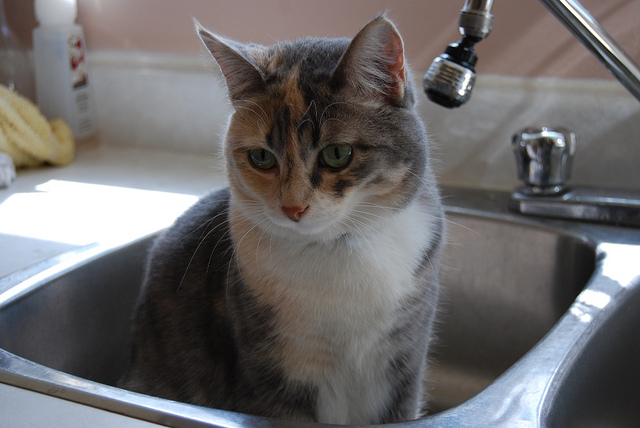

In [12]:
import random
from PIL import Image

def test_random_image():
    # Get a random image from our dataset
    random_idx = random.randint(0, len(dataset.img_ids) - 1)
    img_id = dataset.img_ids[random_idx]
    img_info = dataset.coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataset.root_dir, img_info['file_name'])

    # Get actual captions for comparison
    ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
    anns = dataset.coco.loadAnns(ann_ids)
    actual_captions = [ann['caption'] for ann in anns]

    # Test the model
    test_model('checkpoint_epoch_10.pth', img_path)

    # Print actual captions for comparison
    print("\nActual captions:")
    for i, caption in enumerate(actual_captions, 1):
        print(f"{i}. {caption}")

    # Display the image
    img = Image.open(img_path)
    display(img)

# Run the test
test_random_image()